In [1]:
#################################################### LOAD IMAGES ########################################################

import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def load_limited_images(base_path, image_size=(62, 64), limit_per_class=1600):
    """
    Load images from the dataset with a specified limit per class.

    Args:
        base_path (str): Path to the dataset directory.
        image_size (tuple): Target size for resizing images (width, height).
        limit_per_class (int): Maximum number of images to load per class.

    Returns:
        np.array: Images as NumPy array.
        np.array: Corresponding labels as NumPy array.
    """
    images = []
    labels = []

    for label in range(6):  # Assuming classes are labeled from 0 to 5
        folder_path = os.path.join(base_path, str(label))
        class_images = []
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                class_images.append(img_resized)

            # Stop when the limit is reached
            if len(class_images) >= limit_per_class:
                break

        images.extend(class_images)
        labels.extend([label] * len(class_images))
    
    # Shuffle the dataset
    images, labels = shuffle(images, labels, random_state=42)
    
    return np.array(images), np.array(labels)

# Path to your data
base_path = r"C:\Users\jeremy.hicks\Desktop\School\2024\CSC 546 Advanced AI\Hep-Cells\Organized"

# Load images with a class limit
raw_images, raw_labels = load_limited_images(base_path, limit_per_class=1600)

# Normalize pixel values (CNNs typically expect input in [0, 1])
raw_images = raw_images / 255.0

# Reshape images for CNN input (add channel dimension)
raw_images = raw_images[..., np.newaxis]


# Split data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    raw_images, raw_labels, test_size=0.3, random_state=42, stratify=raw_labels
)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_raw_onehot = to_categorical(y_train_raw, num_classes=6)
y_test_raw_onehot = to_categorical(y_test_raw, num_classes=6)

# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')  # 6 classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.build()
    return model

# Initialize and train the model
cnn_raw_model = create_cnn_model(input_shape=(62, 64, 1))
history_raw = cnn_raw_model.fit(
    X_train_raw, y_train_raw_onehot,
    epochs=10, batch_size=32,
    validation_data=(X_test_raw, y_test_raw_onehot)
)

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.4272 - loss: 1.3258 - val_accuracy: 0.7028 - val_loss: 0.8003
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6911 - loss: 0.8109 - val_accuracy: 0.7316 - val_loss: 0.7541
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7444 - loss: 0.7009 - val_accuracy: 0.8052 - val_loss: 0.5518
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7857 - loss: 0.5801 - val_accuracy: 0.7712 - val_loss: 0.5752
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7965 - loss: 0.5596 - val_accuracy: 0.7271 - val_loss: 0.7335
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8136 - loss: 0.5160 - val_accuracy: 0.7913 - val_loss: 0.5560
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8294 - loss: 0.4904 - val_accuracy: 0.8396 - val_loss: 0.4610
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8387 - loss: 0.4579 - 

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8399 - loss: 0.4812
Test Accuracy on Raw Images: 0.8503
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


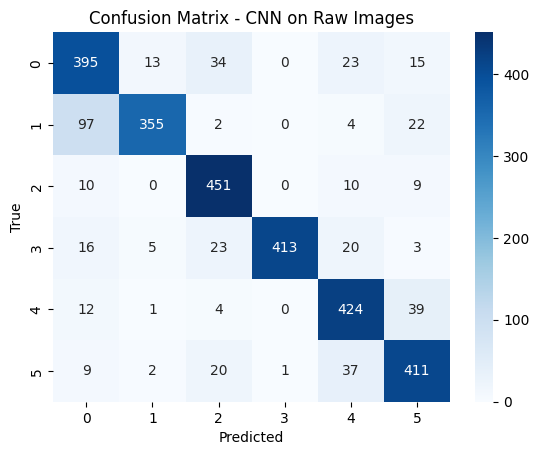

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
test_loss, test_accuracy = cnn_raw_model.evaluate(X_test_raw, y_test_raw_onehot)
print(f"Test Accuracy on Raw Images: {test_accuracy:.4f}")

# Predict labels
y_pred_raw = cnn_raw_model.predict(X_test_raw)
y_pred_raw_classes = np.argmax(y_pred_raw, axis=1)

# Confusion Matrix
conf_matrix_raw = confusion_matrix(y_test_raw, y_pred_raw_classes)
sns.heatmap(conf_matrix_raw, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN on Raw Images")
plt.show()

In [4]:
print(X_test_raw.shape)
#print(cnn_raw_model.build())
X_test_raw = np.transpose(X_test_raw, (0, 2, 1, 3))  # Swap width and height if needed
print(X_test_raw.shape)
print(cnn_raw_model.inputs[0])

(2880, 64, 62, 1)
(2880, 62, 64, 1)
<KerasTensor shape=(None, 62, 64, 1), dtype=float32, sparse=False, name=keras_tensor>


In [5]:
#X_test_raw = X_test_raw[..., np.newaxis]          # Add channel dimension if missing
#print(X_test_raw.shape)  # Should print (num_samples, 62, 64, 1)
#X_test_raw = np.squeeze(X_test_raw, axis=(3, 4))  # Remove dimensions at index 3 and 4
#print(X_test_raw.shape)  # Should print (num_samples, 62, 64)

#cnn_raw_model.build(input_shape=(None, 62, 64, 1))  # Include None for batch size
#cnn_raw_model.fit(X_train_raw, y_train_raw_onehot, epochs=1, batch_size=32)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


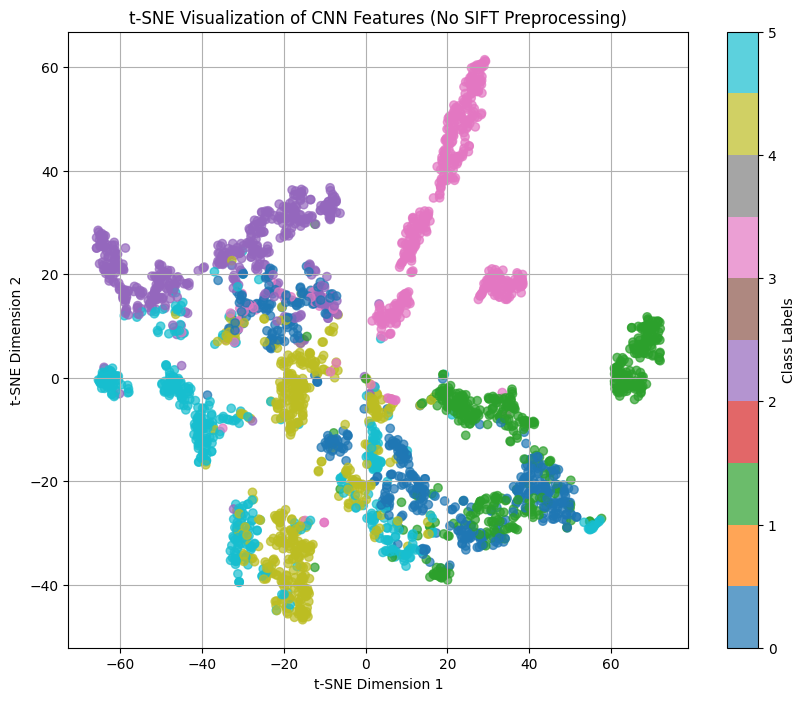

In [6]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Define the feature extractor using .history.model.inputs
feature_extractor = Model(
    inputs=cnn_raw_model.history.model.inputs[0],
    outputs=cnn_raw_model.get_layer("dense").output
)

# Extract features from the test data
features = feature_extractor.predict(X_test_raw)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the 2D t-SNE output
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test_raw, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of CNN Features (No SIFT Preprocessing)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


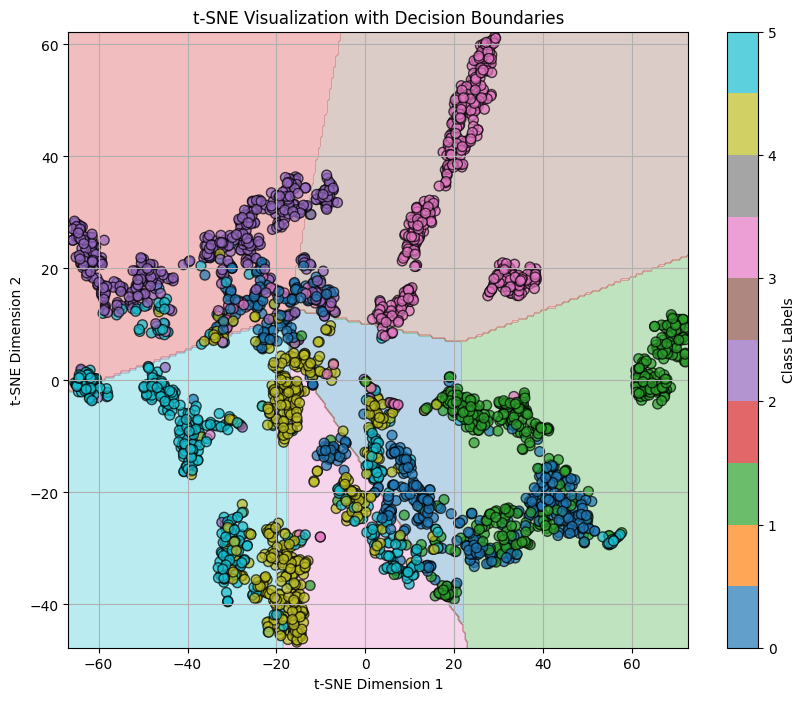

In [7]:
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

# Train a classifier on the t-SNE features
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(features_2d, y_test_raw)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = features_2d[:, 0].min() - 1, features_2d[:, 0].max() + 1
y_min, y_max = features_2d[:, 1].min() - 1, features_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))

# Predict the class for each point in the mesh grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')  # Decision boundaries
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test_raw, cmap='tab10', edgecolor='k', s=50, alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization with Decision Boundaries")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

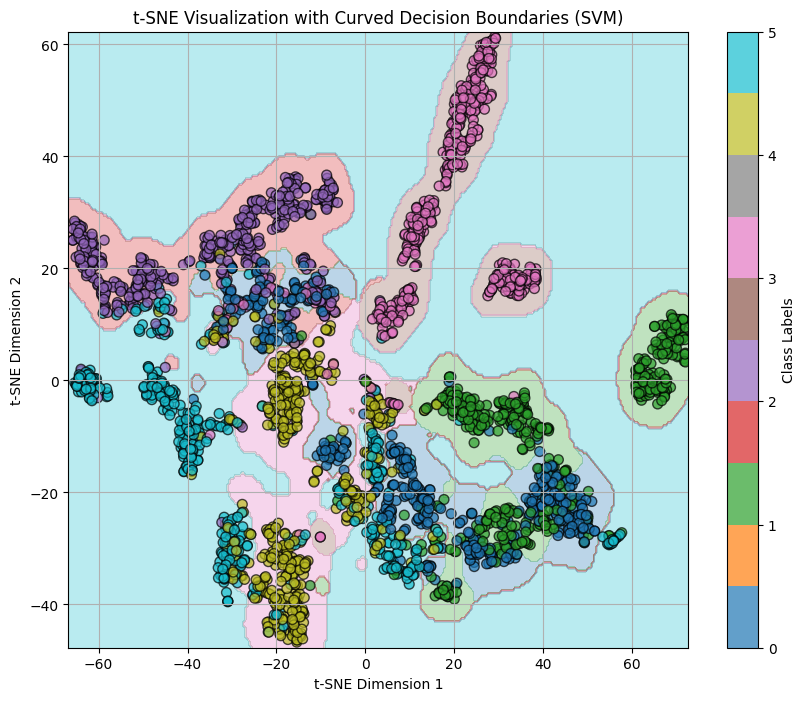

In [8]:
from sklearn.svm import SVC

# Train an SVM classifier with an RBF kernel
clf = SVC(kernel='rbf', C=1, gamma=0.1, probability=True, random_state=42)
clf.fit(features_2d, y_test_raw)

# Predict the class for each point in the mesh grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')  # Curved decision boundaries
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test_raw, cmap='tab10', edgecolor='k', s=50, alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization with Curved Decision Boundaries (SVM)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1934/1934 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step


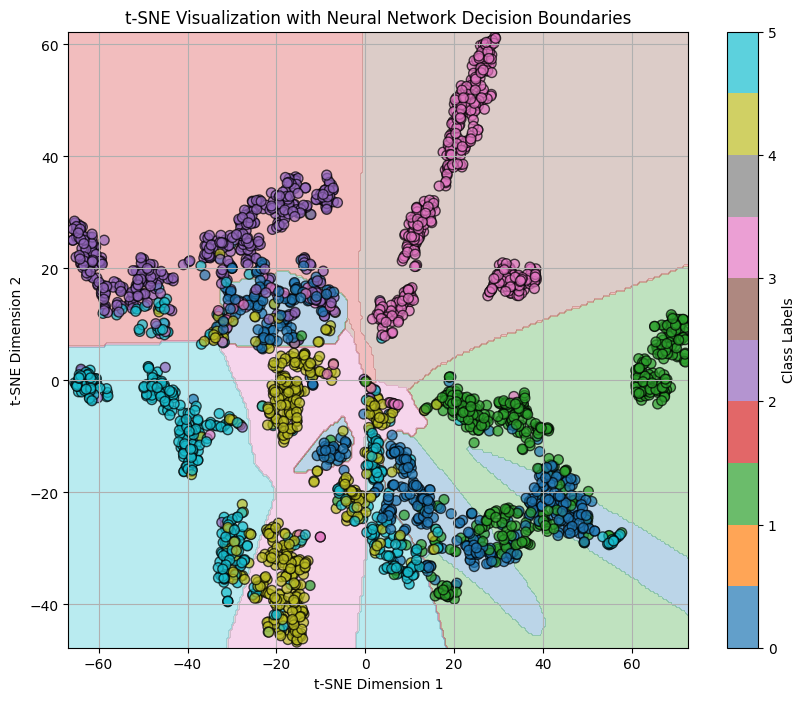

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Train a simple neural network
nn_clf = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax')  # 6 classes
])
nn_clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_clf.fit(features_2d, y_test_raw, epochs=50, batch_size=32, verbose=0)

# Predict class probabilities for mesh grid points
Z = np.argmax(nn_clf.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')  # Curved decision boundaries
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test_raw, cmap='tab10', edgecolor='k', s=50, alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization with Neural Network Decision Boundaries")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress tracking

def enhance_contrast(image, clip_limit=2.0):
    """Enhance contrast of an image using CLAHE with a customizable clipLimit."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    return clahe.apply(image)

def extract_sift_keypoints(image):
    """Detect SIFT keypoints in an image."""
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(image, None)
    return len(keypoints)

def load_balanced_images_with_dynamic_contrast(base_path, image_size=(62, 64), max_per_class=1000, keypoint_threshold=100, max_iterations=5):
    """
    Load a balanced subset of images and iteratively enhance contrast until keypoints reach threshold.
    
    Args:
        base_path (str): Root directory containing label subfolders (e.g., 0, 1, 2...).
        image_size (tuple): Target size for resizing images.
        max_per_class (int): Maximum number of images to load per class.
        keypoint_threshold (int): Minimum keypoints; enhance contrast until keypoints reach this value.
        max_iterations (int): Maximum number of contrast enhancement iterations.
        
    Returns:
        np.array: List of processed image arrays.
        np.array: Corresponding labels for the images.
    """
    images = []
    labels = []
    enhanced_indices = []  # Track which images were enhanced

    for label in range(6):  # Labels are 0 to 5
        folder_path = os.path.join(base_path, str(label))
        all_files = os.listdir(folder_path)

        # Randomly shuffle files to avoid bias
        np.random.shuffle(all_files)

        # Limit to the desired number of images per class
        for file_name in tqdm(all_files[:max_per_class], desc=f"Loading Class {label}"):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, image_size)

                # Initial keypoint detection
                keypoint_count = extract_sift_keypoints(img_resized)
                iterations = 0
                
                # Keep enhancing the contrast until keypoints reach the threshold or max iterations are reached
                while keypoint_count < keypoint_threshold and iterations < max_iterations:
                    img_resized = enhance_contrast(img_resized, clip_limit=2.0 + 1.0 * iterations)  # Gradually increase clipLimit
                    keypoint_count = extract_sift_keypoints(img_resized)
                    iterations += 1
                
                if iterations > 0:
                    enhanced_indices.append((label, file_name))  # Track enhanced images

                images.append(img_resized)
                labels.append(label)
    
    print(f"Enhanced contrast for {len(enhanced_indices)} images with low keypoints.")
    return np.array(images), np.array(labels)

# Example Usage
base_path = r"C:\Users\jeremy.hicks\Desktop\School\2024\CSC 546 Advanced AI\Hep-Cells\Organized"
max_per_class = 1600  # Adjust based on dataset
images, labels = load_balanced_images_with_dynamic_contrast(base_path, max_per_class=max_per_class)

print(f"Loaded {len(images)} images with {len(np.unique(labels))} labels.")

Loading Class 5: 100%|█████████████████████████████████████████████████████████████| 1600/1600 [00:21<00:00, 73.47it/s]

Enhanced contrast for 9600 images with low keypoints.
Loaded 9600 images with 6 labels.


In [11]:
from tqdm import tqdm

def preprocess_images_with_progress(images):
    """
    Extract SIFT features for a batch of images with a progress bar.
    
    Args:
        images (np.array): Array of preprocessed images.
        
    Returns:
        sift_descriptors (np.array): Combined SIFT descriptors from all images.
        image_descriptor_indices (list): List of indices mapping images to their descriptors.
    """
    sift_descriptors = []
    image_descriptor_indices = []  # To map which descriptors belong to which image
    #sift = cv2.SIFT_create()
    sift = cv2.SIFT_create(nfeatures=5000)
    
    for idx, image in enumerate(tqdm(images, desc="Extracting SIFT features")):
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            sift_descriptors.extend(descriptors)
            image_descriptor_indices.extend([idx] * len(descriptors))  # Map descriptors to image index
    
    return np.array(sift_descriptors), image_descriptor_indices

# Example Usage
sift_features, descriptor_indices = preprocess_images_with_progress(images)

print(f"Total SIFT descriptors extracted: {sift_features.shape}")
print(f"Descriptor mapping to images: {len(descriptor_indices)} descriptors mapped.")

Extracting SIFT features: 100%|███████████████████████████████████████████████████| 9600/9600 [00:22<00:00, 420.07it/s]


Total SIFT descriptors extracted: (774296, 128)
Descriptor mapping to images: 774296 descriptors mapped.


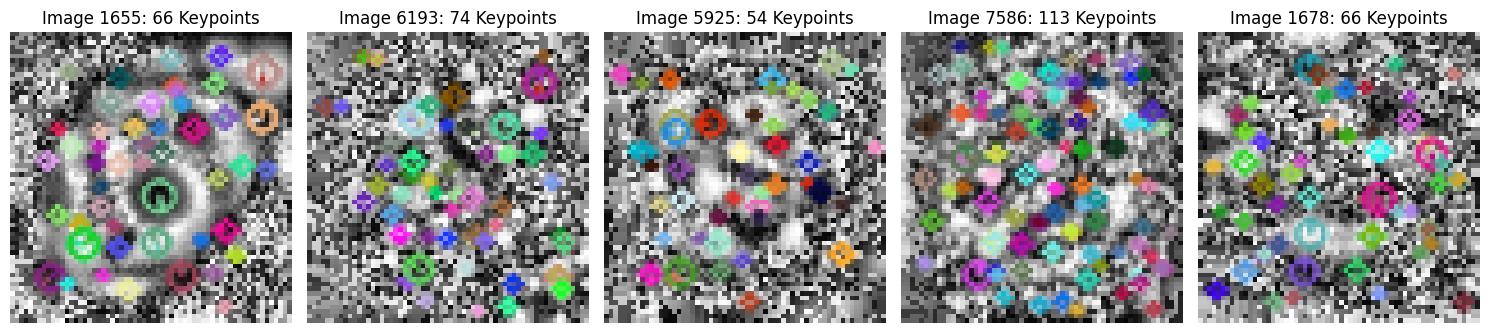

In [12]:
import matplotlib.pyplot as plt

def visualize_sift_keypoints(images, num_samples=5):
    """
    Visualize SIFT keypoints for a random sample of images.
    
    Args:
        images (np.array): Array of preloaded grayscale images.
        num_samples (int): Number of images to visualize.
    """
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        img = images[idx]
        sift = cv2.SIFT_create()
        keypoints, _ = sift.detectAndCompute(img, None)
        img_with_keypoints = cv2.drawKeypoints(
            img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_with_keypoints, cmap='gray')
        plt.axis('off')
        plt.title(f"Image {idx}: {len(keypoints)} Keypoints")
    
    plt.tight_layout()
    plt.show()

# Example Usage
visualize_sift_keypoints(images, num_samples=5)


In [13]:
from sklearn.cluster import MiniBatchKMeans
import joblib  # For saving the model
from tqdm import tqdm

def cluster_sift_descriptors_with_progress(sift_features, num_clusters=500, batch_size=1000, max_iter=300):
    """
    Cluster SIFT descriptors using MiniBatchKMeans with a progress bar for iterations.
    
    Args:
        sift_features (np.array): Array of SIFT descriptors.
        num_clusters (int): Number of clusters (visual words).
        batch_size (int): Batch size for MiniBatchKMeans.
        max_iter (int): Maximum number of iterations for MiniBatchKMeans.
        
    Returns:
        kmeans (MiniBatchKMeans): Trained MiniBatchKMeans model.
    """
    print("Clustering descriptors with MiniBatchKMeans...")
    progress_bar = tqdm(total=max_iter, desc="Clustering Iterations", position=0, leave=True)

    # Initialize MiniBatchKMeans
    kmeans = MiniBatchKMeans(
        n_clusters=num_clusters,
        random_state=42,
        batch_size=batch_size,
        max_iter=max_iter
    )

    # Fit MiniBatchKMeans with a progress bar
    for _ in range(max_iter):
        kmeans.partial_fit(sift_features)  # Incremental fitting
        progress_bar.update(1)

    progress_bar.close()
    return kmeans

# Example Usage
num_clusters = 500  # Number of visual words
sift_features_float64 = sift_features.astype(np.float64)

# Cluster descriptors with a progress bar
kmeans_model = cluster_sift_descriptors_with_progress(sift_features_float64, num_clusters=num_clusters)

# Save the trained KMeans model for later use
joblib.dump(kmeans_model, "kmeans_visual_words.pkl")
print(f"KMeans clustering completed. {num_clusters} visual words created.")


Clustering descriptors with MiniBatchKMeans...


Clustering Iterations: 100%|█████████████████████████████████████████████████████████| 300/300 [12:27<00:00,  2.49s/it]

KMeans clustering completed. 500 visual words created.


Assigning Descriptors to Clusters: 100%|██████████████████████████████████████████| 9600/9600 [00:32<00:00, 295.06it/s]


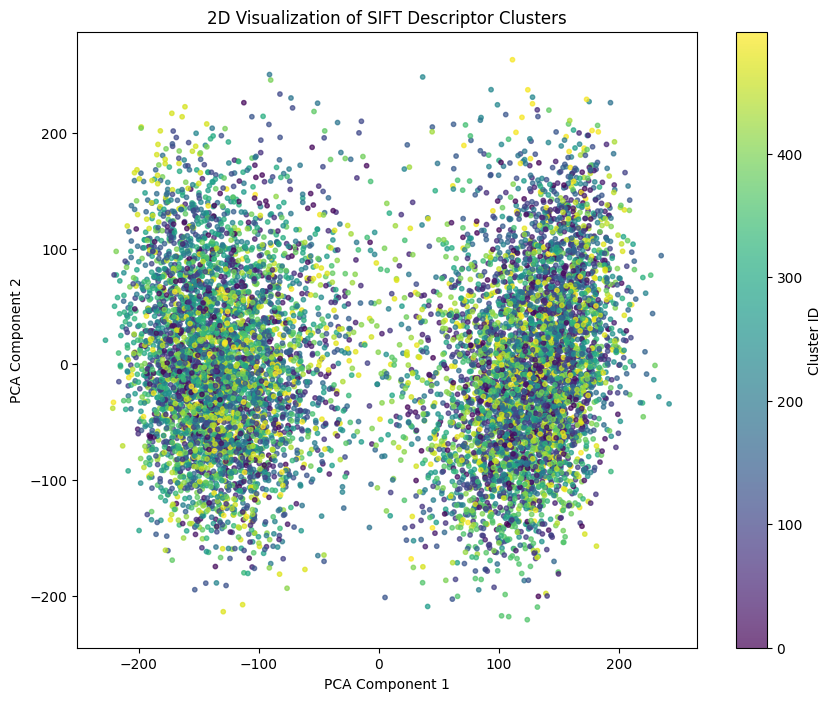

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

def visualize_sift_clusters(sift_features, kmeans_model, num_samples=1600*6):
    """
    Visualize SIFT descriptor clusters in 2D space using PCA, with a progress bar.
    
    Args:
        sift_features (np.array): SIFT descriptors.
        kmeans_model (KMeans): Trained KMeans model.
        num_samples (int): Number of descriptors to sample for visualization.
    """
    # Sample a subset of descriptors for visualization
    sampled_indices = np.random.choice(len(sift_features_float64), num_samples, replace=False)
    sampled_features = sift_features[sampled_indices]
    
    # Ensure descriptors are of the correct type for KMeans prediction
    sampled_features = sampled_features.astype(np.float64)  # Convert to float64
    
    # Predict cluster labels for sampled descriptors with a progress bar
    sampled_labels = []
    for i in tqdm(range(len(sampled_features)), desc="Assigning Descriptors to Clusters"):
        # Ensure input to predict() is 2D (shape: (1, n_features))
        sampled_labels.append(kmeans_model.predict([sampled_features[i]])[0])
    sampled_labels = np.array(sampled_labels)
    
    # Reduce dimensions using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(sampled_features)
    
    # Plot the clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=sampled_labels, cmap='viridis', s=10, alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title("2D Visualization of SIFT Descriptor Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Example Usage
visualize_sift_clusters(sift_features_float64, kmeans_model)

In [15]:
print(f"sift_features dtype: {sift_features_float64.dtype}")
print(f"kmeans_model.cluster_centers_ dtype: {kmeans_model.cluster_centers_.dtype}")
#print(f"sampled_features dtype: {kmeans_model.dtype}")

sift_features dtype: float64
kmeans_model.cluster_centers_ dtype: float64


In [16]:
def extract_sift_features(image):
    """
    Extract SIFT descriptors from an image.

    Args:
        image (numpy array): Input grayscale image.

    Returns:
        descriptors (numpy array or None): SIFT descriptors for the image,
                                           or None if no keypoints are found.
    """
    sift = cv2.SIFT_create()  # Initialize SIFT
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors


#import numpy as np
from scipy.spatial.distance import cdist

def generate_bovw_histograms(images, kmeans_model):
    """
    Generate Bag of Visual Words (BoVW) histograms for a set of images.
    
    Args:
        images (np.array): Array of preloaded images.
        kmeans_model (KMeans): Trained KMeans model.
        
    Returns:
        histograms (np.array): Array of BoVW histograms for each image.
    """
    num_clusters = kmeans_model.n_clusters
    histograms = []
    
    for image in tqdm(images, desc="Generating BoVW histograms"):
        descriptors = extract_sift_features(image)
        #print(f"descriptors: {descriptors.dtype}")
        if descriptors is not None:
            # Assign each descriptor to the nearest cluster center
            cluster_assignments = kmeans_model.predict(descriptors.astype(np.float64))
            # Create a histogram of visual words
            histogram, _ = np.histogram(cluster_assignments, bins=num_clusters, range=(0, num_clusters))
        else:
            # If no descriptors, use an empty histogram
            histogram = np.zeros(num_clusters)
        
        # Normalize the histogram
        histogram = histogram / np.sum(histogram) if np.sum(histogram) > 0 else histogram
        histograms.append(histogram)
    
    return np.array(histograms)

# Example Usage
bovw_histograms = generate_bovw_histograms(images, kmeans_model)
print(f"Generated BoVW histograms with shape: {bovw_histograms.shape}")

Generating BoVW histograms: 100%|█████████████████████████████████████████████████| 9600/9600 [00:54<00:00, 174.64it/s]

Generated BoVW histograms with shape: (9600, 500)


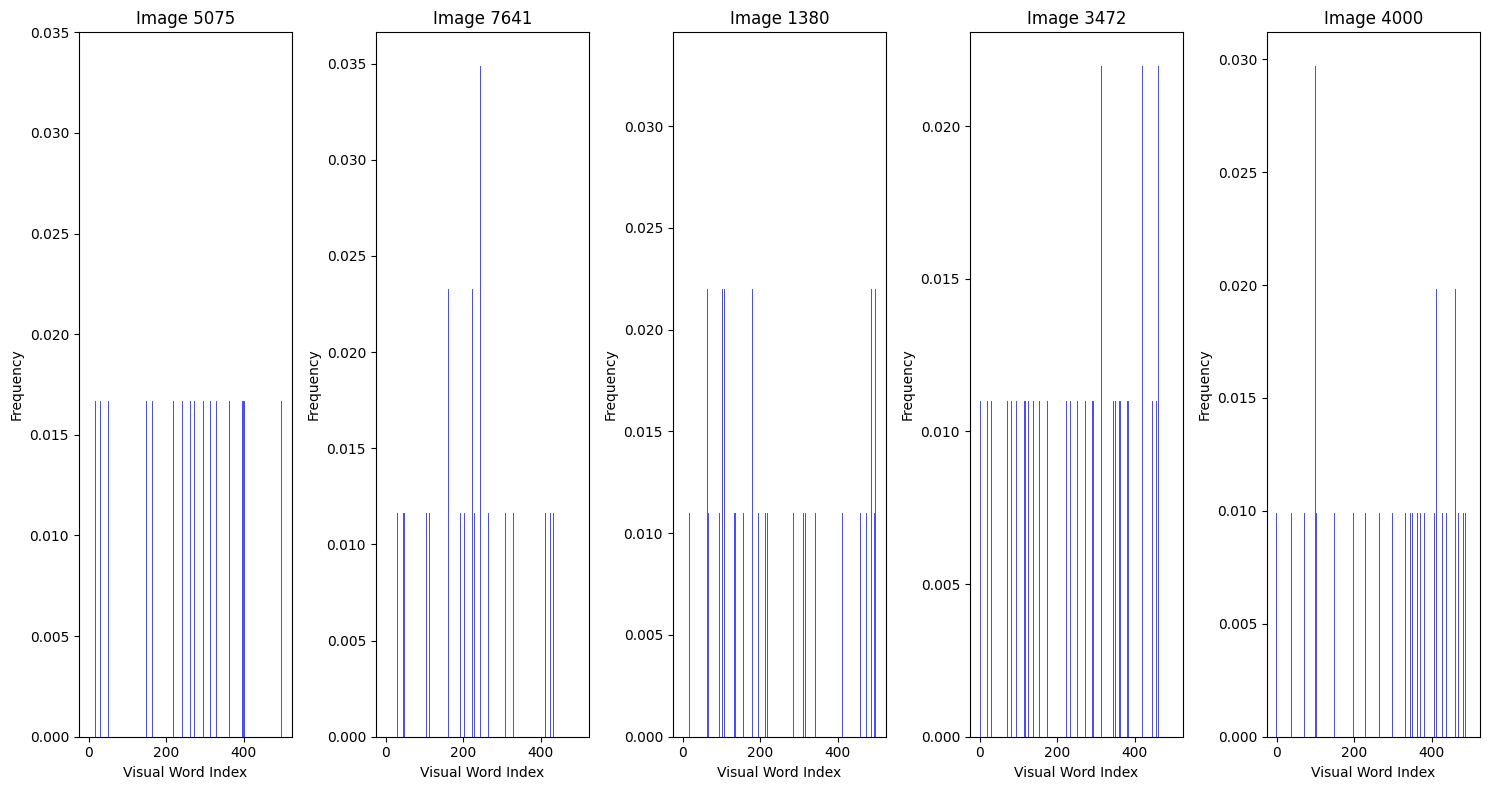

In [17]:
def visualize_bovw_histograms(bovw_histograms, num_samples=5):
    """
    Visualize Bag of Visual Words (BoVW) histograms for a sample of images.
    
    Args:
        bovw_histograms (np.array): Array of BoVW histograms.
        num_samples (int): Number of histograms to visualize.
    """
    sample_indices = np.random.choice(len(bovw_histograms), num_samples, replace=False)
    plt.figure(figsize=(15, 8))
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.bar(range(len(bovw_histograms[idx])), bovw_histograms[idx], color='blue', alpha=0.7)
        plt.title(f"Image {idx}")
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.tight_layout()
    
    plt.show()

# Example Usage
visualize_bovw_histograms(bovw_histograms, num_samples=5)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming `bovw_histograms` contains the feature vectors for your images
# and `labels` contains the corresponding labels for each image

# Split the data into training and testing sets
og_X_train, og_X_test, og_y_train, og_y_test = train_test_split(
    bovw_histograms, labels, test_size=0.3, random_state=42, stratify=labels
)

# Standardize the data (important for SVM, KNN, etc.)
scaler = StandardScaler()
og_X_train_scaled = scaler.fit_transform(og_X_train)
og_X_test_scaled = scaler.transform(og_X_test)

print(f"Training set size: {og_X_train_scaled.shape[0]}, Test set size: {og_X_test_scaled.shape[0]}")


Training set size: 6720, Test set size: 2880


Class Distribution: Counter({np.int64(4): 1120, np.int64(3): 1120, np.int64(1): 1120, np.int64(2): 1120, np.int64(0): 1120, np.int64(5): 1120})


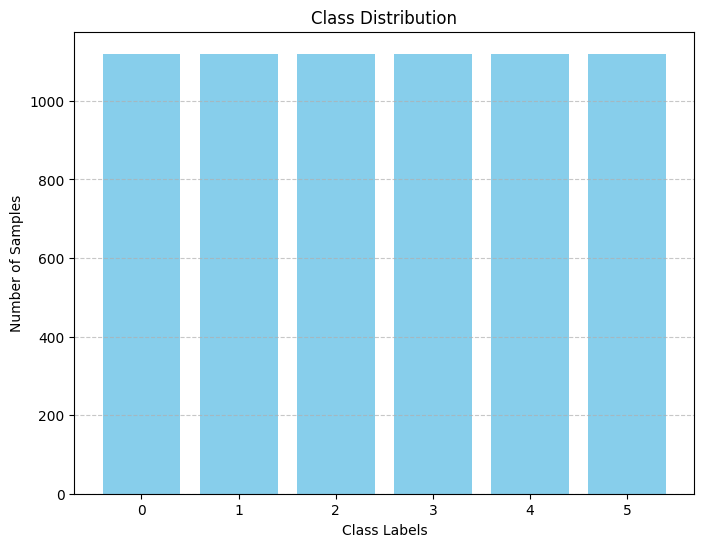

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming `y_train` contains the labels for your training set
def plot_class_distribution(labels):
    """
    Plot class distribution to check for balance.
    """
    class_counts = Counter(labels)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    # Print class distribution
    print("Class Distribution:", class_counts)

    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example: Visualize training set labels
plot_class_distribution(og_y_train)


In [20]:
# SVM (Support Vector Machine)
# Key Hyperparameters:

# C: Regularization parameter. Controls the trade-off between a smooth decision boundary and correctly classifying training points.
# Low C: Allows for misclassification but simplifies the decision boundary.
# High C: Focuses on classifying every point correctly, potentially overfitting.
# Kernel: The function to project data into a higher-dimensional space.
# Common choices: 'linear', 'rbf', 'poly', 'sigmoid'.
# Gamma (for 'rbf' and 'poly' kernels): Controls the influence of a single training example.
# Low gamma: A point has far-reaching influence.
# High gamma: Focuses on nearby points only.
# Degree (for 'poly' kernel): Determines the degree of the polynomial kernel.
# Class weight: Handles imbalanced classes by weighting them.

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time

# Train an SVM model with progress bar
def train_svm_with_progress(og_X_train_scaled, og_y_train):
    
    svm_model = SVC(
        kernel='linear',  # Try a different kernel
        C=10,          # Increase regularization
        gamma=0.1,     # Manually set gamma
        class_weight='balanced',  # Handle class imbalance
        random_state=42
    )
    svm_model.fit(og_X_train_scaled, og_y_train)
    
    return svm_model

# Train the SVM with progress
svm_model = train_svm_with_progress(og_X_train_scaled, og_y_train)

# Predict on the test set
svm_y_pred = svm_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, svm_y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.31      0.28       480
           1       0.24      0.25      0.24       480
           2       0.32      0.33      0.33       480
           3       0.30      0.28      0.29       480
           4       0.28      0.27      0.27       480
           5       0.60      0.49      0.54       480

    accuracy                           0.32      2880
   macro avg       0.33      0.32      0.33      2880
weighted avg       0.33      0.32      0.33      2880



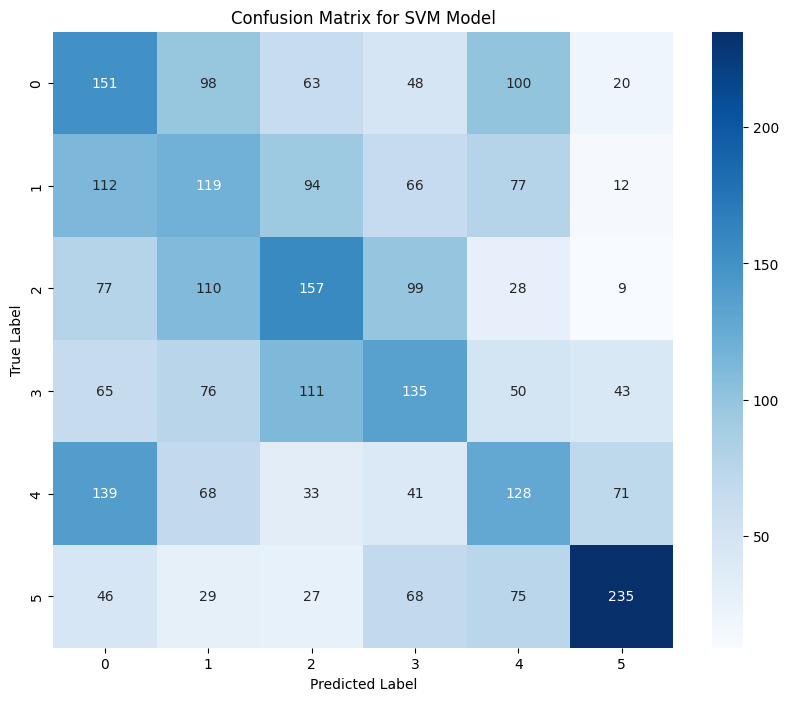

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(og_y_test, svm_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


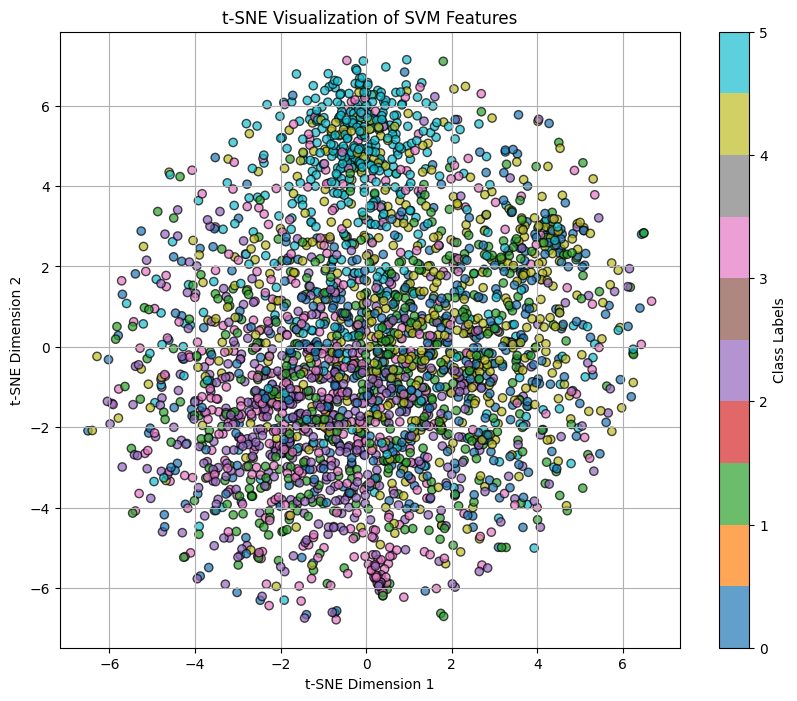

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the high-dimensional test data
tsne = TSNE(n_components=2, random_state=42)
og_X_test_2d = tsne.fit_transform(og_X_test_scaled)

# Plot the 2D t-SNE output
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    og_X_test_2d[:, 0], og_X_test_2d[:, 1],
    c=og_y_test, cmap='tab10', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of SVM Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

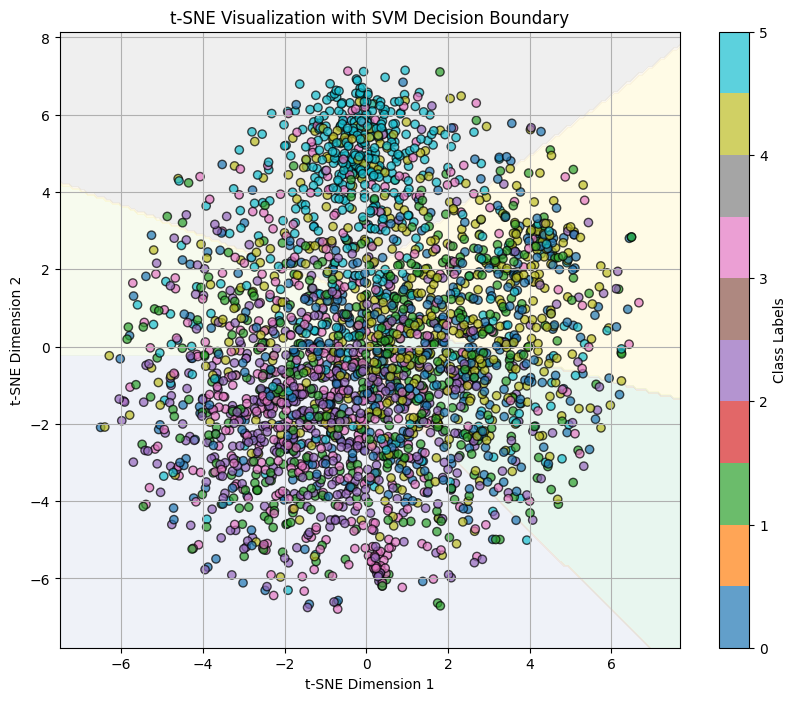

In [24]:
from sklearn.svm import SVC
import numpy as np

# Train an SVM on the t-SNE-transformed data
svm_tsne = SVC(
        kernel='linear',  # Try a different kernel
        C=1.0,          # Increase regularization
        gamma=0.1,     # Manually set gamma
        class_weight='balanced',  # Handle class imbalance
        random_state=42
    )
svm_tsne.fit(og_X_test_2d, og_y_test)

# Create a meshgrid for the t-SNE feature space
x_min, x_max = og_X_test_2d[:, 0].min() - 1, og_X_test_2d[:, 0].max() + 1
y_min, y_max = og_X_test_2d[:, 1].min() - 1, og_X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

# Predict on the meshgrid
Z = svm_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot t-SNE visualization with SVM decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')  # Decision boundary
scatter = plt.scatter(
    og_X_test_2d[:, 0], og_X_test_2d[:, 1],
    c=og_y_test, cmap='tab10', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization with SVM Decision Boundary")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


Performing cross-validation for KNN...


Evaluating KNN for different k: 100%|██████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Optimal k: 19
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.05      0.09       496
           1       0.20      0.18      0.19       483
           2       0.29      0.17      0.21       473
           3       0.22      0.71      0.34       465
           4       0.32      0.15      0.21       479
           5       0.69      0.55      0.62       484

    accuracy                           0.30      2880
   macro avg       0.34      0.30      0.28      2880
weighted avg       0.34      0.30      0.27      2880



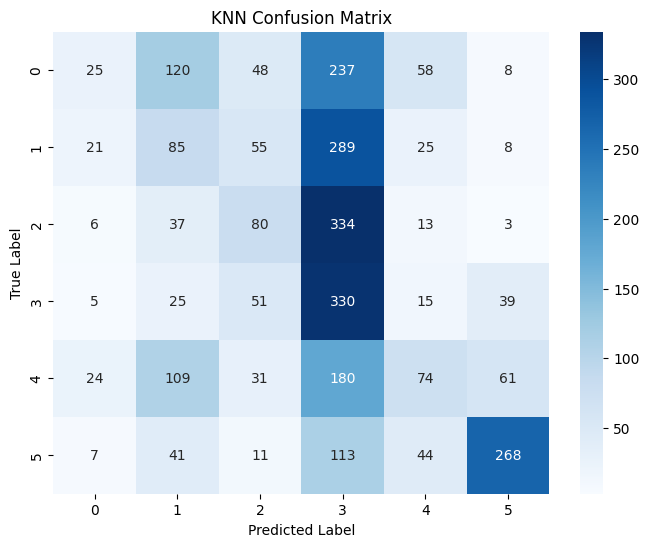

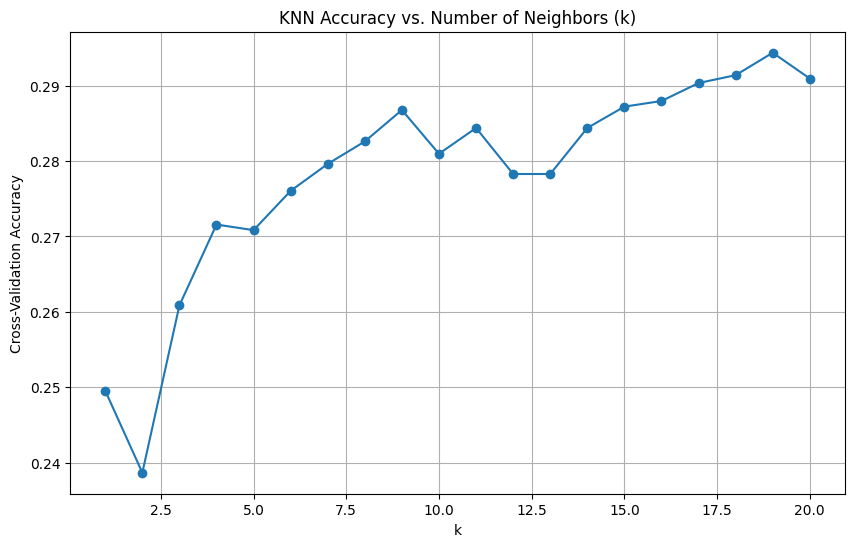

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Split data (if not already split)
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(
    bovw_histograms, labels, test_size=0.3, random_state=42
)

# Try different values of k
k_values = range(1, 21)  # Range of k values (number of neighbors); common values: 1-50
cv_scores = []

print("Performing cross-validation for KNN...")
for k in tqdm(k_values, desc="Evaluating KNN for different k"):
    knn = KNeighborsClassifier(
        n_neighbors=k,  # Number of neighbors to consider
        weights='uniform',  # How to weight points: 'uniform' or 'distance' (distance weights closer neighbors more)
        algorithm='auto',  # Algorithm used to compute neighbors ('auto', 'ball_tree', 'kd_tree', 'brute')
        leaf_size=30,  # Leaf size for tree-based algorithms; impacts speed and memory (common values: 10-50)
        p=2  # Power parameter for Minkowski distance (1 = Manhattan, 2 = Euclidean, other values for Minkowski)
    )
    scores = cross_val_score(
        knn, 
        knn_X_train, 
        knn_y_train, 
        cv=5,  # Number of cross-validation folds (common values: 3-10)
        scoring='accuracy'  # Scoring metric; options include 'accuracy', 'f1', 'roc_auc', etc.
    )
    cv_scores.append(scores.mean())

# Select the best k
optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}")

# Train final KNN model with the optimal k
knn_final = KNeighborsClassifier(
    n_neighbors=optimal_k,  # Optimal number of neighbors
    weights='uniform',      # Keeping the same weight scheme as above
    algorithm='auto',       # Using the same algorithm as above
    leaf_size=30,           # Same leaf size
    p=2                     # Same power parameter
)
knn_final.fit(knn_X_train, knn_y_train)

# Predict and evaluate
knn_y_pred = knn_final.predict(knn_X_test)
print("Classification Report:\n", classification_report(knn_y_test, knn_y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(knn_y_test, knn_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("k")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.31      0.31       480
           1       0.28      0.24      0.26       480
           2       0.33      0.35      0.34       480
           3       0.33      0.29      0.31       480
           4       0.31      0.27      0.29       480
           5       0.56      0.72      0.63       480

    accuracy                           0.36      2880
   macro avg       0.35      0.36      0.36      2880
weighted avg       0.35      0.36      0.36      2880



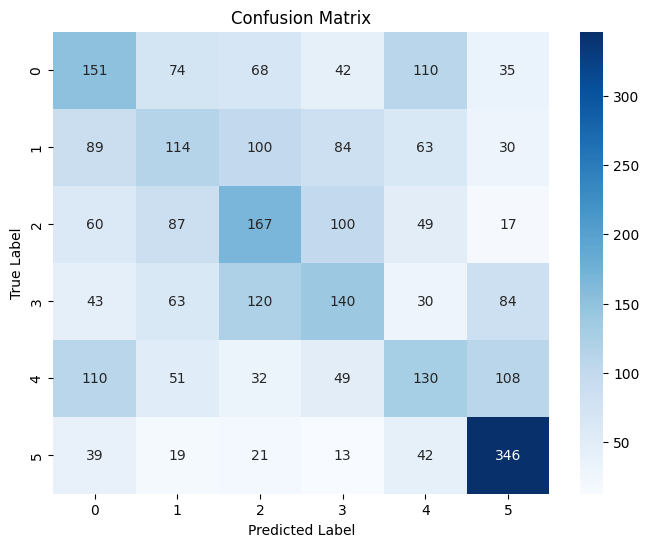

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Train a Random Forest model
def train_random_forest(og_X_train_scaled, og_y_train, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features="sqrt"):
    """
    Train a Random Forest classifier with detailed hyperparameters.
    
    Args:
        og_X_train_scaled (np.array): Scaled training features.
        og_y_train (np.array): Training labels.
        n_estimators (int): Number of trees in the forest.
        max_depth (int or None): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
        max_features (str or int): The number of features to consider when looking for the best split.
    
    Returns:
        model: Trained Random Forest model.
    """
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,  # Number of trees in the forest
        max_depth=max_depth,        # Maximum depth of each tree (None = nodes expanded until pure)
        min_samples_split=min_samples_split,  # Min samples required to split
        min_samples_leaf=min_samples_leaf,    # Min samples required at a leaf
        max_features=max_features,  # Max features considered for the best split
        random_state=42             # Random seed for reproducibility
    )
    
    rf_model.fit(og_X_train_scaled, og_y_train)
    return rf_model

# Train the Random Forest model
rf_model = train_random_forest(
    og_X_train_scaled, 
    og_y_train,
    n_estimators=100,       # Default number of trees
    max_depth=None,         # Default: fully grown trees
    min_samples_split=2,    # Default: 2 samples required to split a node
    min_samples_leaf=1,     # Default: 1 sample required per leaf node
    max_features="sqrt"     # Equivalent to 'auto' in older versions
)

# Predict on the test set
rf_y_pred = rf_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, rf_y_pred))

# Plot the confusion matrix
def plot_confusion_matrix(og_y_test, rf_y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(og_y_test, rf_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(og_y_test), yticklabels=np.unique(og_y_test))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(og_y_test, rf_y_pred)


Training XGBoost model...


C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.28      0.27       480
           1       0.28      0.26      0.27       480
           2       0.32      0.34      0.33       480
           3       0.35      0.34      0.34       480
           4       0.29      0.29      0.29       480
           5       0.62      0.61      0.61       480

    accuracy                           0.35      2880
   macro avg       0.35      0.35      0.35      2880
weighted avg       0.35      0.35      0.35      2880



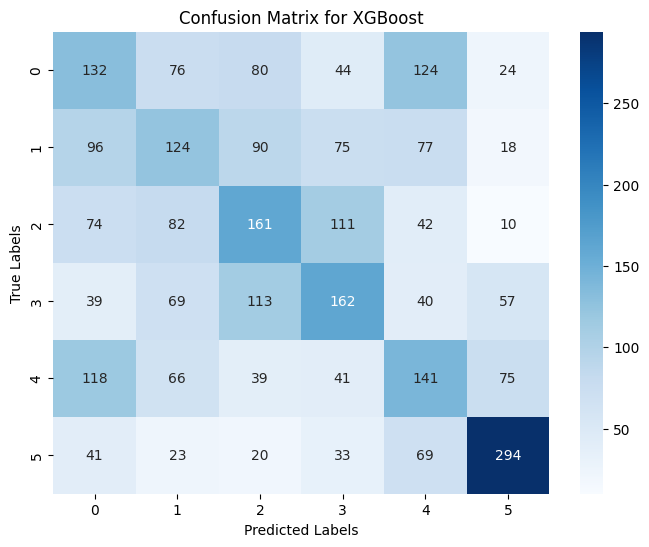

In [27]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def train_xgboost(og_X_train_scaled, og_y_train):
    """Train XGBoost model."""
    print("Training XGBoost model...")
    
    # Create the XGBoost classifier
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=6,  # Assuming 6 classes (0-5)
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    model.fit(og_X_train_scaled, og_y_train)
    return model

# Example Usage
xgb_model = train_xgboost(og_X_train_scaled, og_y_train)

# Predict on the test set
xgb_y_pred = xgb_model.predict(og_X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(og_y_test, xgb_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(og_y_test, xgb_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(og_y_test), yticklabels=np.unique(og_y_test))
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Decision Tree Accuracy: 0.2703
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.22      0.21       320
           1       0.24      0.25      0.25       320
           2       0.23      0.23      0.23       320
           3       0.27      0.27      0.27       320
           4       0.24      0.24      0.24       320
           5       0.45      0.41      0.43       320

    accuracy                           0.27      1920
   macro avg       0.27      0.27      0.27      1920
weighted avg       0.27      0.27      0.27      1920



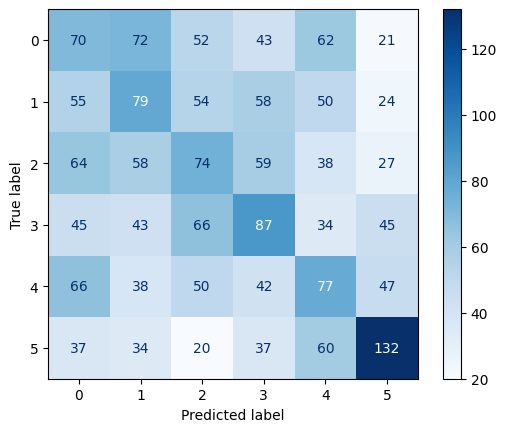

In [28]:
#print(X_train_scaled.shape)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Assuming BoVW histograms are ready as `bovw_histograms` and labels as `labels`
# Split the data into train and test sets
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(bovw_histograms, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize and train the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(dt_X_train, dt_y_train)

# Make predictions
dt_y_pred = decision_tree.predict(dt_X_test)

# Evaluate the model
accuracy = accuracy_score(dt_y_test, dt_y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(dt_y_test, dt_y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(dt_y_test, dt_y_pred, display_labels=[0, 1, 2, 3, 4, 5], cmap="Blues")

In [29]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_from_folders(base_path, image_size=(62, 64), num_images_per_class=1000):
    """
    Load images and labels from a directory structure, ensuring a balanced dataset with a limited number of images per class.
    
    Args:
        base_path (str): Root directory containing label subfolders (e.g., 0, 1, 2...).
        image_size (tuple): Target size for resizing images.
        num_images_per_class (int): Maximum number of images to load per class.
        
    Returns:
        images (np.array): Array of preprocessed image arrays.
        labels (np.array): Array of corresponding labels for the images.
    """
    images = []
    labels = []

    for label in range(6):  # labels are 0 to 5
        folder_path = os.path.join(base_path, str(label))
        class_images = []  # Store all images from the current class
        
        # Collect all images for the current class
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, image_size)  # Resize to 62x64
                class_images.append(img_resized)
        
        # Limit the number of images for each class (randomly select up to `num_images_per_class` images)
        class_images = np.array(class_images)  # Convert to numpy array
        if len(class_images) > num_images_per_class:
            # Randomly select num_images_per_class images
            indices = np.random.choice(len(class_images), num_images_per_class, replace=False)
            class_images = class_images[indices]
        
        # Append the selected images and labels to the final dataset
        images.extend(class_images)
        labels.extend([label] * len(class_images))

    return np.array(images), np.array(labels)

# Example Usage
base_path = r"C:\Users\jeremy.hicks\Desktop\School\2024\CSC 546 Advanced AI\Hep-Cells\Organized"
num_images_per_class = 1600  # Limit the number of images per class
images, labels = load_images_from_folders(base_path, num_images_per_class=num_images_per_class)
print(f"Loaded {len(images)} images with {len(np.unique(labels))} labels.")

# Normalize the images
images = images.astype('float32') / 255.0  # Normalize pixel values

# Reshape for CNN
refr_X_reshaped = images.reshape(-1, 62, 64, 1)  # Shape for CNN input
print(f"Reshaped images: {refr_X_reshaped.shape}")

# Split the data into training and testing sets
refr_X_train, refr_X_test, refr_y_train, refr_y_test = train_test_split(refr_X_reshaped, labels, test_size=0.5, random_state=42)

# Verify the split
print(f"Training data: {refr_X_train.shape}, Testing data: {refr_X_test.shape}")
print(f"Initial X_train shape: {refr_X_train.shape}")
print(f"Initial y_train shape: {refr_y_train.shape}")
print(f"Initial X_test shape: {refr_X_test.shape}")
print(f"Initial y_test shape: {refr_y_test.shape}")
#print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
#print(f"y_train_one_hot shape: {y_train_one_hot.shape}")

Loaded 9600 images with 6 labels.
Reshaped images: (9600, 62, 64, 1)
Training data: (4800, 62, 64, 1), Testing data: (4800, 62, 64, 1)
Initial X_train shape: (4800, 62, 64, 1)
Initial y_train shape: (4800,)
Initial X_test shape: (4800, 62, 64, 1)
Initial y_test shape: (4800,)


In [30]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding of labels
y_train_one_hot = to_categorical(refr_y_train, num_classes=6)
y_test_one_hot = to_categorical(refr_y_test, num_classes=6)

# Check the shapes of the one-hot encoded labels
print(f"y_train_one_hot shape: {y_train_one_hot.shape}")
print(f"y_test_one_hot shape: {y_test_one_hot.shape}")


y_train_one_hot shape: (4800, 6)
y_test_one_hot shape: (4800, 6)


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Prepare the data
#X_train_reshaped = images.reshape(-1, 62, 64, 1)  # Shape for CNN input: (num_samples, height, width, 1)
#X_test_reshaped = X_test.reshape(-1, 62, 64, 1)  # Assuming X_test is loaded and processed similarly

# Convert labels to one-hot encoding
#y_train_one_hot = to_categorical(y_train, num_classes=6)
#y_test_one_hot = to_categorical(y_test, num_classes=6)

# Normalize images to [0, 1] range (if not already done)
#X_train_reshaped = X_train_reshaped.astype('float32') / 255.0
#X_test_reshaped = X_test_reshaped.astype('float32') / 255.0

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(62, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(refr_X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(refr_X_test, y_test_one_hot))

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(refr_X_test, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and classification report
cnn_y_pred = cnn_model.predict(refr_X_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)  # Convert predictions to class labels

# Evaluate performance with classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(refr_y_test, cnn_y_pred_classes))

Epoch 1/10


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.2582 - loss: 1.6911 - val_accuracy: 0.4352 - val_loss: 1.3798
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.4209 - loss: 1.3806 - val_accuracy: 0.4873 - val_loss: 1.2288
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.4701 - loss: 1.2611 - val_accuracy: 0.4985 - val_loss: 1.1713
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.5031 - loss: 1.1959 - val_accuracy: 0.5323 - val_loss: 1.1468
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5272 - loss: 1.1638 - val_accuracy: 0.5577 - val_loss: 1.0948
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5633 - loss: 1.0989 - val_accuracy: 0.5727 - val_loss: 1.0611
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5717 - loss: 1.0815 - val_accuracy: 0.5788 - val_loss: 1.0427
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5705 - loss: 1.0459 - val_accuracy: 0.57

Overall Accuracy for CNN with SIFT: 0.5994
Classification Report for CNN with SIFT:
               precision    recall  f1-score   support

 Homogeneous       0.49      0.48      0.49       852
    Speckled       0.58      0.70      0.63       792
   Nucleolar       0.76      0.45      0.57       796
  Centromere       0.76      0.59      0.67       807
 Cytoplasmic       0.51      0.65      0.57       777
    Negative       0.63      0.73      0.67       776

    accuracy                           0.60      4800
   macro avg       0.62      0.60      0.60      4800
weighted avg       0.62      0.60      0.60      4800



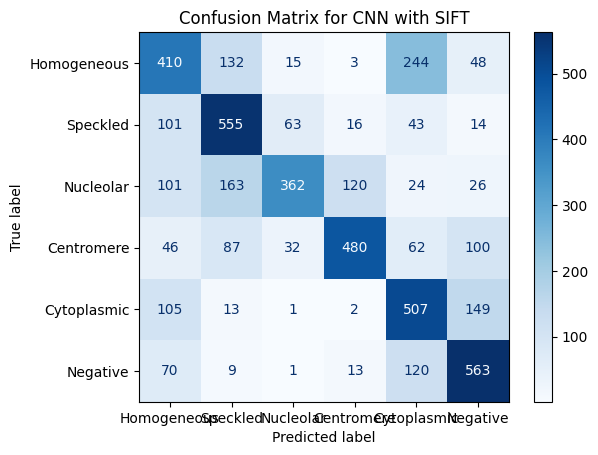

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Evaluate model accuracy
accuracy = accuracy_score(refr_y_test, cnn_y_pred_classes)
print(f"Overall Accuracy for CNN with SIFT: {accuracy:.4f}")

# Generate classification report
class_names = ["Homogeneous", "Speckled", "Nucleolar", "Centromere", "Cytoplasmic", "Negative"]  # Replace if different
report = classification_report(refr_y_test, cnn_y_pred_classes, target_names=class_names)
print("Classification Report for CNN with SIFT:\n", report)

# Generate and display confusion matrix
cm = confusion_matrix(refr_y_test, cnn_y_pred_classes, labels=range(6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CNN with SIFT")
plt.show()


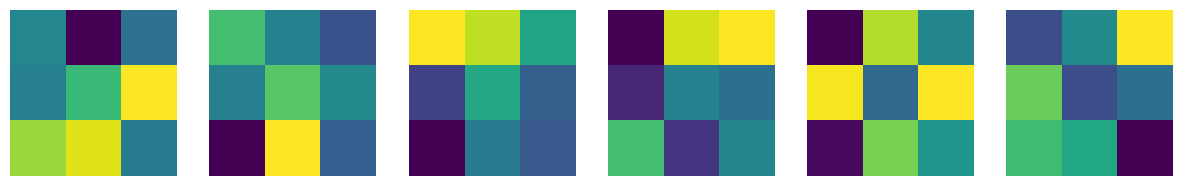

In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

# Extract filters from the first convolutional layer
layer = cnn_model.layers[0]
filters, biases = layer.get_weights()

# Normalize filter values for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the first few filters
n_filters = 6  # Number of filters to visualize
fig, axes = plt.subplots(1, n_filters, figsize=(15, 5))
for i in range(n_filters):
    ax = axes[i]
    ax.imshow(filters[:, :, 0, i], cmap='viridis')
    ax.axis('off')
plt.show()

In [34]:
# Example predictions for all models (replace these with your model predictions)
predictions_svm = svm_model.predict(og_X_test_scaled)
predictions_knn = knn_final.predict(og_X_test_scaled)
predictions_rf = rf_model.predict(og_X_test_scaled)
predictions_dt = decision_tree.predict(og_X_test_scaled)
predictions_xgb = xgb_model.predict(og_X_test_scaled)
predictions_cnn = np.argmax(cnn_model.predict(refr_X_test), axis=1)  # For CNN

predictions_cnn = predictions_cnn[:len(og_y_test)]

# Combine predictions into a list
all_predictions = [
    predictions_svm,
    predictions_knn,
    predictions_rf,
    predictions_dt,
    predictions_xgb,
    predictions_cnn,
]


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [35]:
from collections import Counter
import numpy as np

# Transpose predictions so that each row represents predictions for a single sample
all_predictions = np.array(all_predictions).T

# Apply majority voting
final_predictions = []
for preds in all_predictions:
    # Count occurrences of each class and select the majority class
    most_common = Counter(preds).most_common(1)[0][0]
    final_predictions.append(most_common)

# Convert to a NumPy array for evaluation
final_predictions = np.array(final_predictions)


In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate metrics
accuracy = accuracy_score(og_y_test, final_predictions)
conf_matrix = confusion_matrix(og_y_test, final_predictions)

# Print results
print(f"Ensemble Model Accuracy (Majority Voting): {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(og_y_test, final_predictions))

Ensemble Model Accuracy (Majority Voting): 0.3927
Confusion Matrix:
[[165  94  60  35 104  22]
 [ 87 161  77  61  76  18]
 [ 60 119 173  81  33  14]
 [ 50  76 102 150  38  64]
 [115  58  37  31 154  85]
 [ 34  31  14  24  49 328]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.34      0.33       480
           1       0.30      0.34      0.32       480
           2       0.37      0.36      0.37       480
           3       0.39      0.31      0.35       480
           4       0.34      0.32      0.33       480
           5       0.62      0.68      0.65       480

    accuracy                           0.39      2880
   macro avg       0.39      0.39      0.39      2880
weighted avg       0.39      0.39      0.39      2880



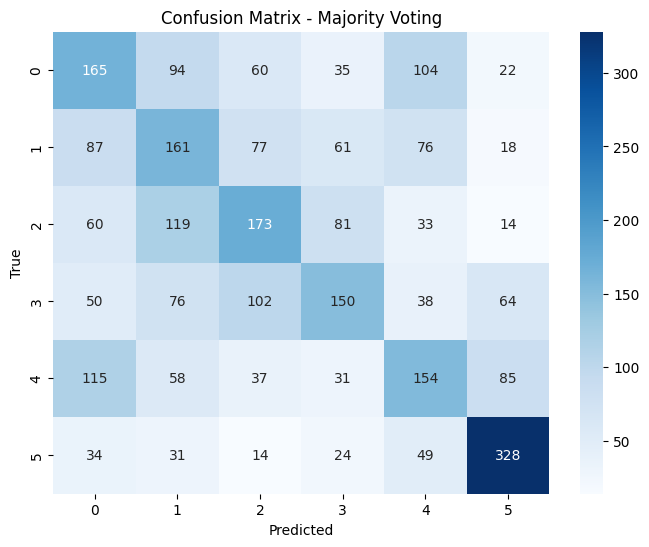

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Majority Voting")
plt.show()
